In [389]:
import pandas as pd
import numpy as np

import z1_save_oligos, z2_save_jaspar
oligos_all, oligos_by_exp_all = z1_save_oligos.load_oligos()
oligos = oligos_all.loc[lambda df: df.mutant_num != 5].copy()
oligos_by_exp = oligos_by_exp_all.loc[lambda df: df.mutant_num !=5].copy()
jaspar = z2_save_jaspar.load_jaspar()


In [4]:


wt_oligos = oligos.loc[lambda df: df.mutant_num == 0]
starts = wt_oligos.starts.sort_values()
diff_prev = pd.Series( (starts - np.roll(starts,1)).values,index = starts.values)
diff_nex = pd.Series((starts - np.roll(starts,-1)).values,index = starts.values)
firsts = diff_prev.loc[lambda df: abs(df) > 30]
lasts = diff_nex.loc[lambda df: abs(df) > 30]

#LOADS BIOLOGICAL MOTIFS AND SCANS ALL SUBREGIONS FOR OCCURENCES
from pyfaidx import Fasta
sequences_fa = Fasta('/cluster/bh0085/genomes/GRCh38.primary_assembly.genome.fa')
chrseq = str(sequences_fa["chr22"])
region_bounds=[ 38699734, 39291007]
chrreg = chrseq[region_bounds[0]:region_bounds[1]]
intervals = pd.concat([pd.Series(firsts.index.values).rename("start"), pd.Series(lasts.index.values + 120).rename("end")],axis =1)
intervals["seq"] = intervals.apply(lambda x:chrseq[ region_bounds[0]+ x.start: region_bounds[0] +x.end], axis = 1)

import Bio
from Bio.Alphabet import IUPAC
seqseq = intervals.seq.apply(lambda x: Bio.Seq.Seq(x,alphabet = Bio.Alphabet.IUPAC.IUPACUnambiguousDNA))
pwm_r60_grid = jaspar.iloc[::10].apply(lambda  j: seqseq.iloc[::10].apply(lambda x: list( j.pssm.search(str(x),threshold = j.threshold_patser))),axis=1)




In [427]:
interval_motif_hits = pwm_r60_grid.copy()
interval_motif_hits.columns = interval_motif_hits.columns.rename("interval_id")
interval_motif_hits.index.name = "jaspar_id"
interval_motif_hits_series = interval_motif_hits.unstack()
motif_hits = interval_motif_hits_series.\
    groupby(level =["interval_id", "jaspar_id"]).\
    apply(lambda g: pd.Series({intervals.loc[g.name[0]].start + e[0] 
                                         if e[0] > 0 
                                         else intervals.loc[g.name[0]].end + e[0]:e[1]
                     for r in g for e in r}))
motif_hits_over_threshold = motif_hits.groupby(level="jaspar_id").apply(lambda x: x  - jaspar.loc[x.name].threshold_patser).loc[lambda x: x > 0]
motif_hits_over_threshold.index.levels[2].rename("position", inplace=True)
motif_info = motif_hits_over_threshold.rename("score").reset_index()[["jaspar_id","position","score"]]
tmp = motif_info.join(jaspar[["consensus","len","name"]],on = "jaspar_id")
tmp["seq_actual"] = tmp.apply(lambda x: chrreg[x.position:x.position+x["len"]],axis=1)

## CATEGORIZE OLIGO <--> MOTIF EDGES ##
Given a set of all oigos, query for all oligos which either overlap them in wildtype, or as benign / ablating 

In [ ]:
#this code is a little clunky because we're trying to work with indexed queries only ...
oligos["mutant_position"] = oligos.apply(lambda x: x.starts + x.mutant_num  * 30 if x.mutant_num > 0 else np.nan, axis =1)
oligos_by_start_mutant_start = oligos.reset_index().set_index(["starts","mutant_position"]).sort_index(level = ["starts","mutant_position"])
tmp.index.rename("motif_hit_idx",inplace=True)
wt_oligos_by_start = oligos.loc[lambda df: df.mutant_num == 0].reset_index().set_index("starts").sort_index()
idx = pd.IndexSlice


In [482]:

#2d grid representations of relationships b/w motifs & oligos
overlapping_wt_grid = tmp.\
    apply(lambda x : pd.Series(1,
                               index= wt_oligos_by_start.loc[idx[x.position - 180+x["len"]:x.position -30],:].oligo)
          ,axis=1)
ablation_grid = tmp.\
    apply(lambda x : pd.Series(1,
                               index= oligos_by_start_mutant_start.loc[idx[x.position  - 180+x["len"]:x.position ,x.position-29:x.position+x["len"]-1],:].oligo)
          ,axis=1)
mutants_before= \
    tmp.\
    apply(lambda x : pd.Series(1,
                               index= oligos_by_start_mutant_start.loc[idx[x.position  - 180+x["len"]:x.position ,:x.position-30],:].oligo)
          ,axis=1)
mutants_after= \
    tmp.\
    apply(lambda x : pd.Series(1,
                               index= oligos_by_start_mutant_start.loc[idx[x.position  - 180+x["len"]:x.position ,x.position+x["len"]:],:].oligo)
          ,axis=1)

overlapping_wildtypes = overlapping_wt_grid.unstack().dropna()
benign_mutants = pd.concat([mutants_before.unstack().dropna(),mutants_after.unstack().dropna()]).sort_index()
ablation_mutants = ablation_grid.unstack().dropna()

In [483]:
#merge hit data
motif_oligos = pd.concat([overlapping_wildtypes.rename("is_overlapping_wt"),
           ablation_mutants.rename("is_ablation_mut"),
           benign_mutants.rename("is_benign_mut")],axis=1)
motif_oligos_data=motif_oligos.reset_index().set_index("motif_hit_idx").join(motif_info).reset_index()
motif_oligos_data.index.rename("motif_oligo_idx", inplace = True)
motif_oligos_data = motif_oligos_data.reset_index().set_index("oligo").join(oligos[["mu"]]).reset_index().set_index("motif_oligo_idx")

#create an annotation column "hit_type" categorizing motif oligo matches according to three types
motif_oligos_data =motif_oligos_data[["is_ablation_mut","is_overlapping_wt","is_benign_mut"]].reset_index().\
    melt(id_vars=["motif_oligo_idx"],var_name="hit_type").dropna().\
    set_index("motif_oligo_idx")[["hit_type"]].\
    join(motif_oligos_data)


motif_oligos_data["seq_actual"] = motif_oligos_data.join(tmp[["seq_actual"]],on="motif_hit_idx")["seq_actual"]

In [515]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

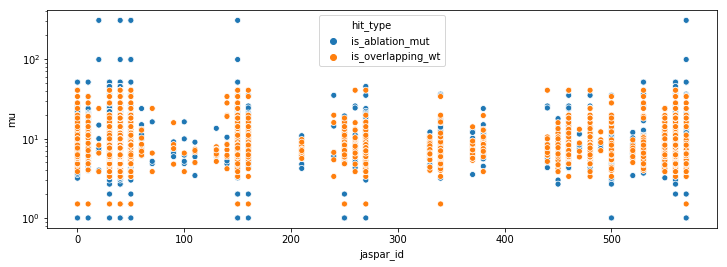

In [526]:
f = plt.gcf()
f.set_size_inches(12,4)
sns.scatterplot(x ="jaspar_id", hue = "hit_type" , estimator=None, y="mu", 
                data = motif_oligos_data.loc[lambda df:df.hit_type != "is_benign_mut"])
ax = plt.gca()
ax.set_yscale("log")

In [ ]:
f = plt.gcf()
f.set_size_inches(12,4)
sns.scatterplot(x ="jaspar_id", hue = "hit_type" , estimator=None, y="mu", 
                data = motif_oligos_data.loc[lambda df:df.hit_type != "is_benign_mut"])
ax = plt.gca()
ax.set_yscale("log")

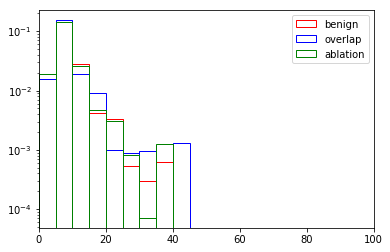

In [543]:
bins = np.arange(0,50,5)

plt.hist(motif_oligos_data.loc[lambda df:df.hit_type=="is_benign_mut"].mu,bins = bins, edgecolor="red", facecolor="none", density=True, label="benign")
plt.hist(motif_oligos_data.loc[lambda df:df.hit_type=="is_overlapping_wt"].mu,bins = bins, edgecolor="blue" , facecolor="none", density=True, label="overlap")
plt.hist(motif_oligos_data.loc[lambda df:df.hit_type=="is_ablation_mut"].mu,bins = bins, edgecolor="green" , facecolor="none", density=True, label="ablation")

plt.legend()
ax = plt.gca()
ax.set_xlim(0,100)
ax.set_yscale("log")

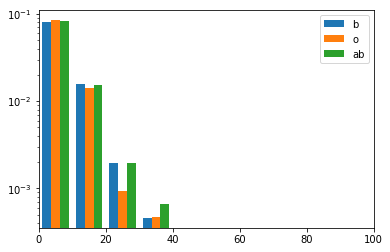

In [550]:
bins = np.arange(0,50,10)

plt.hist([motif_oligos_data.loc[lambda df:df.hit_type=="is_benign_mut"].mu.rename("benign"),
          motif_oligos_data.loc[lambda df:df.hit_type=="is_overlapping_wt"].mu.rename("overlap"),
          motif_oligos_data.loc[lambda df:df.hit_type=="is_ablation_mut"].mu.rename("ablation")]
         ,bins = bins, density=True,label=["b","o","ab"])

plt.legend()
ax = plt.gca()
ax.set_xlim(0,100)
ax.set_yscale("log")

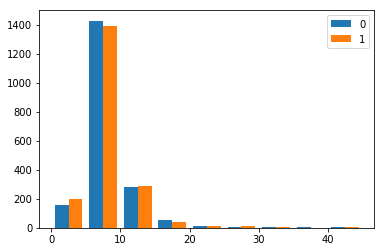

In [562]:
bins = np.arange(0,50,5)

plt.hist([oligos.loc[lambda x: x.mutant_num==0].mu,
          oligos.loc[lambda x: x.mutant_num==1].mu],
         bins = bins,label=["0","1"])
plt.legend()